In [37]:
# usual packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from collections import defaultdict

# machine learning packages
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
%matplotlib inline

import warnings


In [38]:
cosmos = pd.read_csv('match_COSMOS_99_with_err(1).csv')
cosmos=cosmos.loc[:,["B_MAG_APER2","H_MAG_APER2","Hw_MAG_APER2","IA484_MAG_APER2","IA527_MAG_APER2","IA624_MAG_APER2",
            "IA679_MAG_APER2","IA738_MAG_APER2","IA767_MAG_APER2","IB427_MAG_APER2","IB464_MAG_APER2","IB505_MAG_APER2",
            "IB574_MAG_APER2","IB709_MAG_APER2","IB827_MAG_APER2","J_MAG_APER2","Ks_MAG_APER2","Ksw_MAG_APER2",
            "NB711_MAG_APER2","NB816_MAG_APER2","SPLASH_1_MAG","SPLASH_2_MAG","SPLASH_3_MAG","SPLASH_4_MAG","V_MAG_APER2",
            "Y_MAG_APER2","ip_MAG_APER2","r_MAG_APER2","yHSC_MAG_APER2","zpp_MAG_APER2",'zspec']]


In [39]:
def preprocess(df, zspec_drop=True, magnitude_drop=True):
    
    df_new=df.copy()
    print(df_new.shape)
    df_new=df_new.replace({-99.9:random.random()*(df_new.max())})
    if (magnitude_drop==True):
        df_new=df_new[(df_new["IA767_MAG_APER2"]<=22.5) & ( df_new["IA767_MAG_APER2"]>=17)]
    if (zspec_drop == True):
        df_new=df_new[(df_new['zspec']>0)&(df_new['zspec']<=1.5)]
    return df_new.iloc[:,:-1] , df_new.iloc[:,-1]
    print(df_new.shape)
photo_bands,zspec=preprocess(cosmos)
stdScaler= StandardScaler()
stdScaler.fit(photo_bands)
photo_bands=stdScaler.transform(photo_bands)

(391103, 31)


In [40]:
X_train,X_test,Y_train,Y_test = train_test_split(photo_bands, zspec, test_size=0.2)

In [41]:
rf=RandomForestRegressor()
ds=DecisionTreeRegressor()
nn = MLPRegressor()
nHiddenUnits = [100,100,100]
svm = SVR()
knn=KNeighborsRegressor()

param_grid={'RF':{'n_estimators':[5,25,20],'random_state':[0]},'DS':{'random_state':[0]},'NN':{'hidden_layer_sizes':nHiddenUnits,'activation':['relu'],'max_iter':[4000],'random_state':[0]},'SVM':{'C':[1.0],'gamma':['scale']},'KNN':{'n_neighbors':np.arange(1,25)}}
methods_ls={'RF':rf,'DS':ds,'NN':nn,'SVM':svm,'KNN':knn}
z_pres=defaultdict(dict)

In [42]:
for name,instance in methods_ls.items():
    if(param_grid[name] != None):
        print(name)
        gd_srf=GridSearchCV(estimator=instance,param_grid=param_grid[name],cv=5)
        gd_srf.fit(X_train,Y_train)
        z_pres[name]=gd_srf.predict(X_test)
        print('Accuracy',gd_srf.best_score_)
        print('MAE:',metrics.mean_absolute_error(Y_test,z_pres[name]))
        print('RMSE',metrics.mean_squared_error(Y_test,z_pres[name]))
    else:
        raise Exception('error occured')

dict_keys(['RF', 'DS', 'NN', 'SVM', 'KNN'])
RF
Accuracy 0.8052519000233085
MAE: 0.04935542314564088
RMSE 0.0098645527690055
DS
Accuracy 0.626936156678112
MAE: 0.07288111496127192
RMSE 0.02596162555609345
NN
Accuracy 0.6093269540336086
MAE: 0.06080830858191267
RMSE 0.012232028652209731
SVM
Accuracy 0.7856546901334429
MAE: 0.05784869600860093
RMSE 0.010474282567456923
KNN
Accuracy 0.7530881441350992
MAE: 0.055895858132898504
RMSE 0.013752835514227478


In [43]:
def all_sigma(z_predict):
    sigma = np.std(z_predict)
    return sigma

def all_sigma_68(z_predict):
    z_predict_sort = pd.DataFrame(z_predict).sort_values(by=0,ascending=True)
    z_predict_sort = z_predict_sort.reset_index(drop=True)
    
    lower = int (len(z_predict_sort) * 0.16)
    upper = int (len(z_predict_sort) * 0.84)
    data_68 = z_predict_sort[lower:upper]
    sigma_68 = np.std(data_68)
    return sigma_68
    

In [46]:
def metrics(name,z_spec_test,z_predict):
    #to find bins_interval
    plt.figure()
    hist=plt.hist(z_spec_test,bins=90)
    bins_interval = hist[1]
    plt.title('histgram')
    plt.xlabel('z_spec')
    plt.ylabel('predict z_spec')
    data_hist_statitics=pd.DataFrame(columns=["z_predict","z_spec_test","sigma","sigma_68","mean","mean_68"])
    #create an original dataset for predict value and zspec(test) value
    data_hist_statitics["z_predict"] = z_predict
#     print(z_spec_test)
    data_hist_statitics["z_spec_test"] = z_spec_test
    data_hist_statitics["sigma"]=0
    data_hist_statitics["sigma_68"]=0
    data_hist_statitics["mean"]=0
    data_hist_statitics["mean_68"]=0

    data_with_outlier=pd.DataFrame()
    data_without_outlier=pd.DataFrame()
    
    data_outlier=pd.DataFrame()
    z_spec_test_medium=[]
    error_bar_mean=[]
    error_bar_mean_68=[]
    error_bar_std=[]
    error_bar_std_68=[]
    frac_outliers=[]
    frac_outlier_mean=[]
    frac_outlier_std=[]
    for i in range(len(bins_interval)-1):
        lower = bins_interval[i]
        upper = bins_interval[i+1]
        medium = lower/2 + upper/2
        z_spec_test_medium.append(medium)

        #create bin dataset (100%) with outliers
        bin_data = data_hist_statitics[(data_hist_statitics["z_spec_test"]>=lower)&(data_hist_statitics["z_spec_test"]<upper)]
        bin_data["sigma"] = np.std(bin_data["z_predict"])
        bin_data["mean"] = np.mean(bin_data["z_predict"])
        error_bar_mean.append(np.mean(bin_data["z_predict"]))
        error_bar_std.append(np.std(bin_data["z_predict"]))
        data_with_outlier = pd.concat([data_with_outlier,bin_data],ignore_index=True)

        #create 68% each bin dataset without outliers
        lower = np.mean(bin_data["z_predict"]) - np.std(bin_data["z_predict"])
        upper = np.mean(bin_data["z_predict"]) + np.std(bin_data["z_predict"])
        bin_data_68 = bin_data[(bin_data["z_predict"]>=lower)&(bin_data["z_predict"]<upper)]
        bin_data_68["sigma_68"] = np.std(bin_data_68["z_predict"])
        bin_data_68["mean_68"] = np.mean(bin_data_68["z_predict"])
        error_bar_mean_68.append(np.mean(bin_data_68["z_predict"]))
        error_bar_std_68.append(np.std(bin_data_68["z_predict"]))
        data_without_outlier = pd.concat([data_without_outlier,bin_data_68],ignore_index=True)

        #create outlier bin dataset
        bin_data_outlier = bin_data[(bin_data["z_predict"]<lower)|(bin_data["z_predict"]>=upper)]
        bin_data_outlier["fraction"] = (bin_data_outlier["z_predict"] - np.mean(bin_data["z_predict"]))/np.mean(bin_data["z_predict"])
        frac_outlier_mean.append(np.mean(bin_data_outlier["fraction"]))
        frac_outlier_std.append(np.std(bin_data_outlier["fraction"]))
    
#     plt.figure(figsize=(8,15))
#     plt.subplot2grid((12,1),(0,0),rowspan = 4)
    plt.figure(figsize=(7,7))
    plt.scatter(z_spec_test,z_predict,s=3,label='data points')
    plt.errorbar(z_spec_test_medium,error_bar_mean,yerr=error_bar_std,marker='s', fmt='none',color='red',capsize=3,label='error')
    plt.title(name+'--100% sigma variance')
    plt.xlabel('z_spec')
    plt.ylabel('predict z_spec')
    plt.legend()
    plt.savefig(name+'--100% sigma variance')
    plt.ylim([-0.1,1.6])

#     plt.subplot2grid((12,1),(4,0),rowspan = 4)
    plt.figure(figsize=(7,7))
    plt.scatter(z_spec_test,z_predict,s=3,label='data points')
    plt.errorbar(z_spec_test_medium,error_bar_mean_68,yerr=error_bar_std_68,fmt='none',color='red',capsize=3,label='error')
    plt.title(name+'--68% sigma variance')
    plt.xlabel('z_spec')
    plt.ylabel('predict z_spec')
    plt.legend()
    plt.savefig(name+'--68% sigma variance')
    plt.ylim([-0.1,1.6])
    
#     plt.subplot2grid((12,1),(8,0),rowspan = 4)
    plt.figure(figsize=(7,7))
    plt.errorbar(z_spec_test_medium,frac_outlier_mean,yerr=frac_outlier_std,fmt='none',color='red',capsize=3,label='error')
    plt.scatter(z_spec_test_medium,frac_outlier_mean,s=3,label='data points')
    plt.title(name+'----outlier variance')
    plt.xlabel('z_spec')
    plt.ylabel('fraction value')
    plt.legend()
    plt.savefig(name+'----outlier variance')
    plt.ylim([-1,5])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

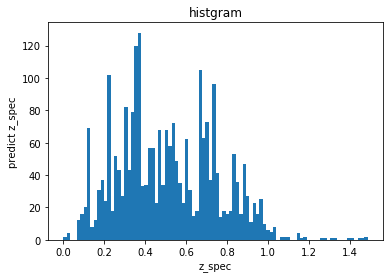

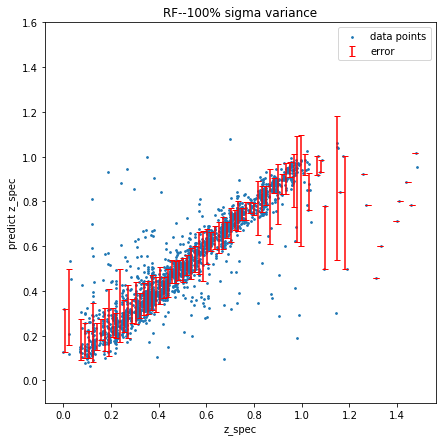

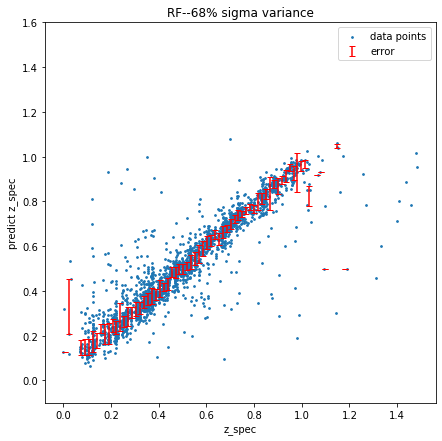

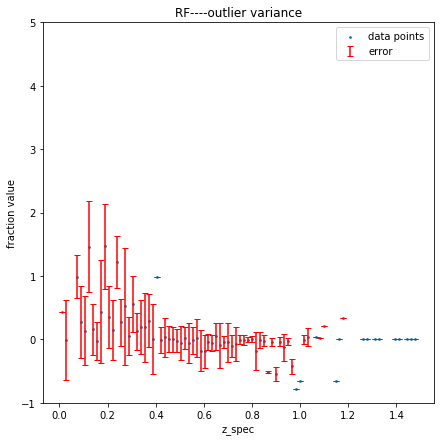

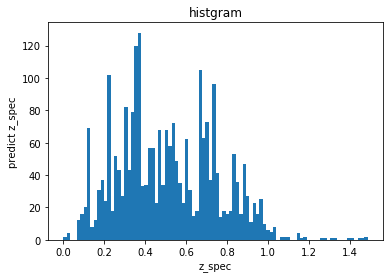

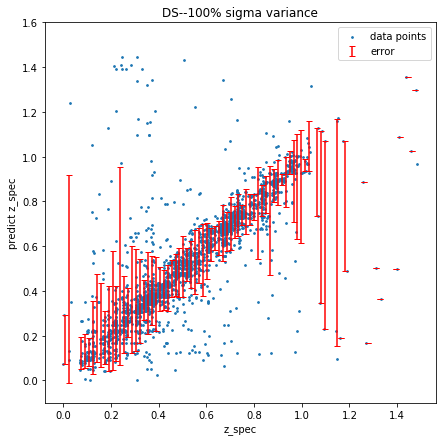

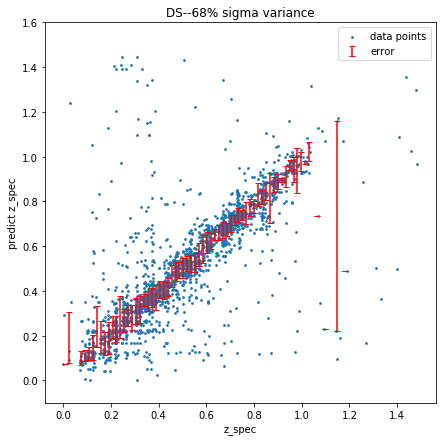

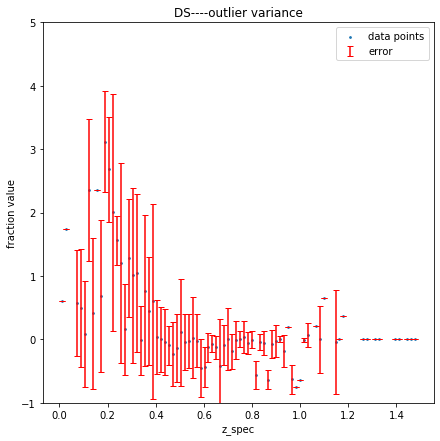

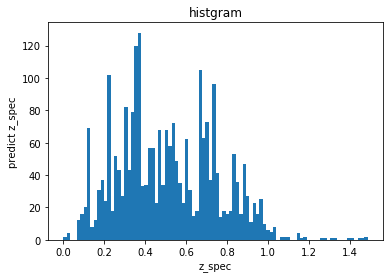

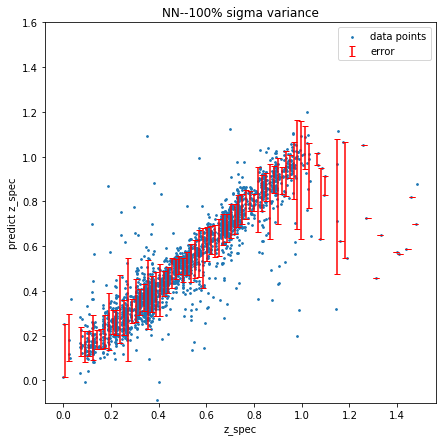

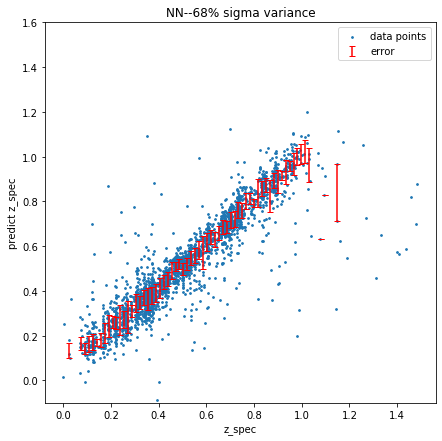

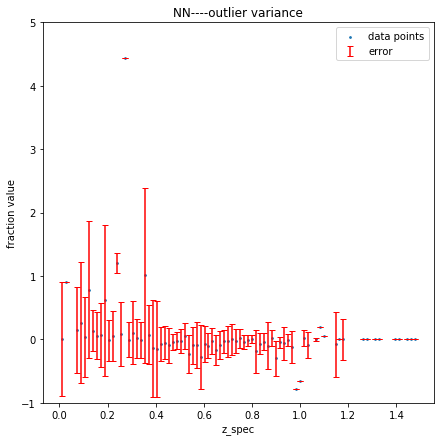

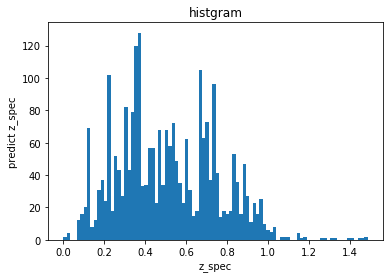

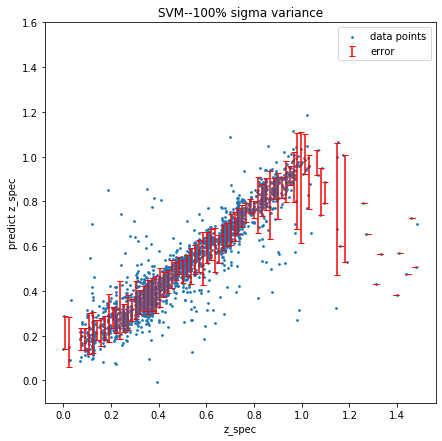

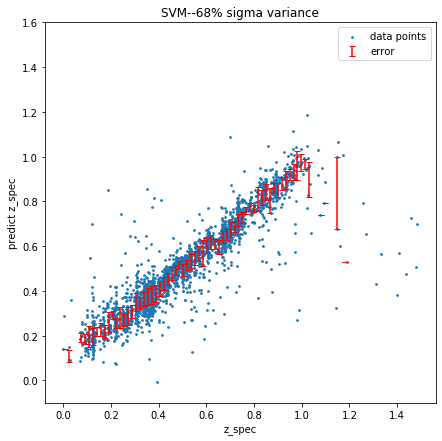

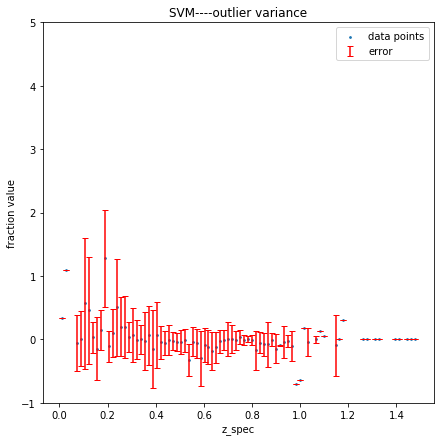

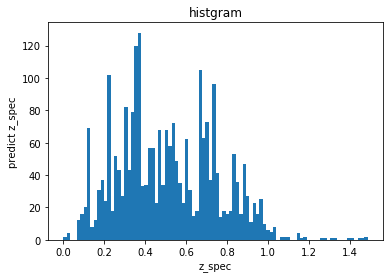

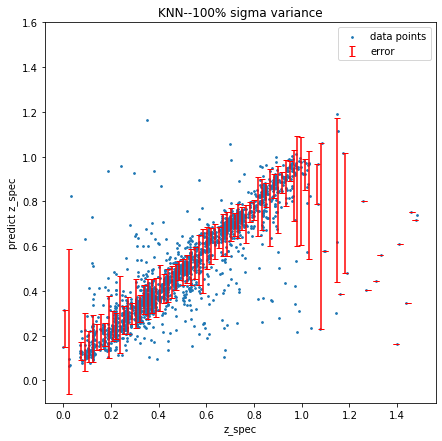

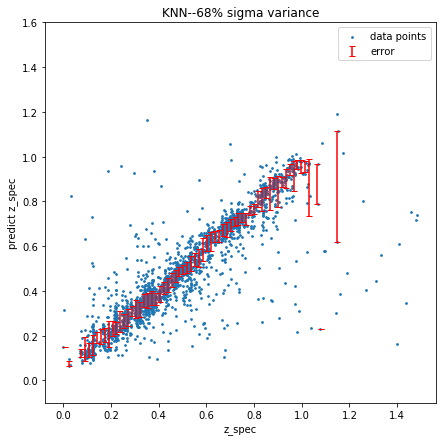

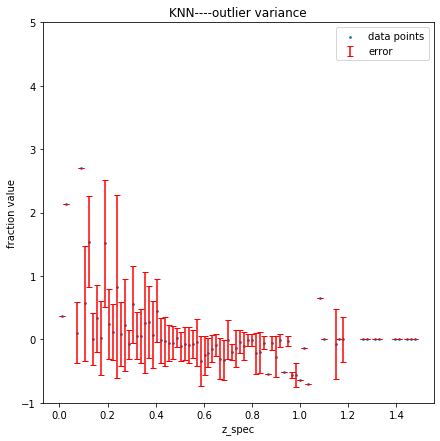

In [47]:
z_spec_test=np.asarray(Y_test)
for name,z_pre in z_pres.items():
    metrics(name,z_spec_test,z_pre)